In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
# Enable tqdm for pandas
tqdm.pandas()
pd.set_option('display.max_columns', None)

In [2]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)
train_len = variables['train_len']
test_len = variables['test_len']
SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']

In [3]:
# read onset dadaset
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/DEMO_KUMC.csv")
# we only need the test set
dataset = dataset.iloc[train_len:, :].copy(deep = True)

In [4]:
# format the data type
dataset[['PATID', 'ONSETS_ENCOUNTERID']] = dataset[['PATID', 'ONSETS_ENCOUNTERID']].astype(str)
time_cols = ["ADMIT_DATE", "DISCHARGE_DATE", "PREDICTION_POINT"]

# Loop through the columns and convert to datetime
for col in time_cols:
    dataset[col] = pd.to_datetime(dataset[col])

Potential Subgroups (defined on demographics/comorbidities):  
1. Black,   
2. 70 years older,   
3. CKD 2, CKD 3,   
4. Diabete Mellitus,   
5. Chronic Liver Disease,   
6. Circulatory System Disease,   
7. Hypertensive Diseases,
8. Ischemic Heart Disease,   
9. Congestive Heart Failure,   
10. Stroke,   
11. Peripheral Vascular Disease.
12. Cancer
13. Metabolic diseases

In [5]:
DX_codes = {
    'CHRONIC_KIDNEY_DISEASES': {'9': ['585.1', '585.2', '585.3', '585.4', '585.5'], 
                                       '10':['N18.1', 'N18.2', 'N18.3', 'N18.30', 'N18.31', 'N18.32', 'N18.4', 'N18.5']},
    'DIABETES_MELLITUS':{'9':['250'], '10': ['E08.9', 'E11.9']},
    'CHRONIC_LIVER_DISEASES':{'9':['571', '571.1', '571.2', '571.3', '571.4', '571.5', '571.6', '571.8', '571.9', '571.40',
                                 '571.41', '571.42', '571.49'], 
                             '10': ['K70', 'K71', 'K72', 'K73', 'K74', 'K75',
                                    'K76', 'K77', 'K70.0', 'K70.1', 'K70.10', 'K70.11',
                                   'K70.2', 'K70.3', 'K70.30', 'K70.31', 'K70.4', 'K70.40', 'K70.41', 'K70.9',
                                   'K71.0', 'K71.1', 'K71.10', 'K71.11', 'K71.2', 'K71.3', 'K71.4', 'K71.5', 'K71.6', 'K71.7',
                                   'K71.8', 'K71.9', 'K72.0', 'K72.1', 'K72.9', 'K72.00', 'K72.01', 'K72.10', 'K72.11',
                                   'K72.90', 'K72.91', 'K73.0', 'K73.1', 'K73.2', 'K73.8', 'K73.9', 'K74.0', 'K74.0', 'K74.1',
                                    'K74.2', 'K74.3', 'K74.4', 'K74.5', 'K74.6', 'K75.0', 'K75.1', 'K75.2', 'K75.3', 'K75.4',
                                   'K75.8', 'K75.9', 'K76.0', 'K76.1', 'K76.2', 'K76.3', 'K76.4', 'K76.5', 'K76.6', 'K76.7', 'K76.8', 'K76.9']},
    'CIRCULATORY_SYSTEM_DISEASES': {'9':['413.9', '410.11', '410.91', '414.01', '414.00', '412',
                                       '414.4', '414.9'], 
                                   '10': ['I20.9', 'I21.09', 'I21.3', 'I25.10', 'I25.2', 'I25.84', 'I25.9']},
    'HYPERTENSIVE_DISEASES':{'9':['401.0', '401.1', '401.9', '402.00', '402.01', '402.10', '402.11', '402.90', '402.91'], 
                            '10': ['I10', 'I11.0', 'I11.9']},
    'ISCHEMIC_HEART_DISEASES':{'9':['410.00', '410.10', '412', '413.9', '414.00', '414.01'], 
                              '10': ['I21.09', 'I25.2', 'I20.9', 'I25.10']},
    'CONGESTIVE_HEART_FAILURE':{'9':['428'], '10': ['I50.22']},
    'STROKE':{'9':['434.91'], '10': ['I63.9']},
    'PERIPHERAL_VASCULAR_DISEASES':{'9':['433.9'], '10': ['I73.9']},
    'METABOLIC_DISEASES': {'9': ['268.9', '272.0', '272.1', '272.2', '272.4', '277.7'], 
                            '10': ['E55.9', 'E78.0', 'E78.1', 'E78.2', 'E78.5', 'E88.81']},
    'CANCERS': {'9': [str(code) for code in range(140, 240)], '10': ['C%s'%(code) for code in range(0, 97)] + ['D%s'%(code) for code in range(0, 50)]}
}

In [6]:
DX_codes_combined = dict()
for name, codes in DX_codes.items():
    DX_codes_combined[name] = codes["9"] + codes["10"]

# Read Comorbidities

In [7]:
DX_cols = ['PATID', 'DX', 'DX_DATE"+PD.DATE_SHIFT"']
DX_df = pd.read_csv('/blue/yonghui.wu/hoyinchan/Data/data2022raw/KUMC_ORCALE/raw/AKI_DX.csv', usecols = DX_cols)

In [8]:
# format the dataframe
DX_df.columns = ['PATID', 'DX_DATE', 'DX']
DX_df[['PATID', 'DX']] = DX_df[['PATID', 'DX']].astype(str)
DX_df['DX_DATE'] = pd.to_datetime(DX_df['DX_DATE'], format = '%d-%b-%y').dt.date
DX_df.dropna(inplace = True)

In [9]:
# merge the onset_df with the filtered_DX_df
dataset_DX_df = dataset.merge(DX_df, on='PATID', how='left')
# filter by admission date
dataset_DX_df = dataset_DX_df[dataset_DX_df['DX_DATE'] < dataset_DX_df['ADMIT_DATE']]

In [10]:
def map_to_disease(DX):
    # DX_codes here is a global variable
    for disease, codes in DX_codes_combined.items():
        if any(DX.startswith(code) for code in codes):
            return disease
    return None

In [11]:
# map the DX to disease
dataset_DX_df.loc[:, 'DX_NAME'] = dataset_DX_df['DX'].progress_apply(map_to_disease)
# delete the rows that cannot be mapped to any disease
dataset_DX_df = dataset_DX_df.dropna(subset=['DX_NAME']).reset_index(drop=True)
dataset_DX_df.drop('DX', axis=1, inplace=True)

100%|██████████| 696860/696860 [00:24<00:00, 28819.73it/s]


In [12]:
# pivot onset_DX_df to get the diagnosis feature, values as binary, index as pat_id_cols and columns as DX
DX_feature_pivot = dataset_DX_df.pivot_table(index=["PATID", "ONSETS_ENCOUNTERID"], 
                                             columns='DX_NAME', aggfunc='size', fill_value=0)
# Convert the pivot table to binary (1 if the patient had the diagnose, 0 otherwise)
DX_feature_pivot = (DX_feature_pivot > 0).astype(int)
# Reset the index to make it a regular dataframe
DX_feature_pivot.reset_index(inplace=True)

In [13]:
def merge_and_filter(onset_df: pd.DataFrame, feature_df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Merge the onset_df with feature_df and filter out the cols that have less than threshold 1 values
    """
    # we keep the original onset_df number of columns and merge the medication feature
    onset_df_fea_num = len(onset_df.columns)
    # merge
    onset_df = onset_df.merge(feature_df, on = ["PATID", "ONSETS_ENCOUNTERID"], how='left')
    # for those do not have a redcord in the observation window, we will fill them with 0
    onset_df.fillna(0, inplace=True)
    
    # drop columns of medications with the rate of 1 less then 1%
    # Calculate the threshold for 1%
    threshold = len(onset_df) * threshold
    # Get the columns to keep based on the threshold
    columns_to_keep = onset_df.columns[:onset_df_fea_num].tolist() + \
                    [col for col in onset_df.columns[onset_df_fea_num:] if onset_df[col].sum() >= threshold]
    # Filter the dataframe to keep only the desired columns
    onset_df = onset_df[columns_to_keep]
    return onset_df


In [14]:
# merge med and filter out the columns that have less than 1% 1 values
dataset = merge_and_filter(dataset, DX_feature_pivot, 0.02)

# Read Demographics

In [15]:
DEMO_df = pd.read_csv("/blue/yonghui.wu/hoyinchan/Data/data2022raw/KUMC_ORCALE/raw/AKI_DEMO.csv", 
                      delimiter = ',', usecols = ['ONSETS_ENCOUNTERID', 'AGE', 'PATID', 'SEX', 'RACE'])

In [16]:
# format the df
DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']] = \
DEMO_df[['PATID', 'ONSETS_ENCOUNTERID', 'SEX', 'RACE']].astype(str)

In [17]:
DEMO_df = DEMO_df.drop_duplicates(subset=["PATID", "ONSETS_ENCOUNTERID"]).reset_index(drop=True)

In [18]:
dataset = dataset.merge(DEMO_df, on = ['PATID', 'ONSETS_ENCOUNTERID'], how = "left")

In [19]:
assert dataset.SEX.isna().mean() == 0
assert dataset.AGE.isna().mean() == 0
assert dataset.RACE.isna().mean() == 0

In [20]:
# Create the "> 70" column: 1 if AGE > 70, else 0
dataset["Age ≥ 70"] = (dataset["AGE"] >= 70).astype(int)

# Create the "MALE" column: 1 if SEX == "M", else 0
dataset["MALE"] = (dataset["SEX"] == "M").astype(int)

# Create the "BLACK" column: 1 if RACE == "03", else 0
dataset["BLACK"] = (dataset["RACE"] == "03").astype(int)

# Read Model Predictions

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [22]:
pred_prob_KNN = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/subgroup_pred_probs_KNN.csv")
pred_prob_LR = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/subgroup_pred_probs_LR.csv")

In [23]:
# sanity check
assert len(dataset) == len(pred_prob_KNN)
assert len(dataset) == len(pred_prob_LR)

In [24]:
cols_to_keep = ["AKI_LABEL"] + ["CANCERS", "METABOLIC_DISEASES", "CHRONIC_LIVER_DISEASES", "CIRCULATORY_SYSTEM_DISEASES", 
                                "CHRONIC_KIDNEY_DISEASES", "CONGESTIVE_HEART_FAILURE", "DIABETES_MELLITUS", "HYPERTENSIVE_DISEASES", 
                                "Age ≥ 70", "MALE", "BLACK"]

In [25]:
dataset_filtered = dataset.loc[:, cols_to_keep].copy(deep = True)

In [26]:
dataset_full = pd.concat([dataset_filtered, pred_prob_KNN, pred_prob_LR], axis = 1)

In [35]:
subgroup_KNN_performance = dict()
for subgroup_name in dataset_filtered.columns[1:]:
    subgroup_KNN_performance[subgroup_name] = dict()
    subgroupp = dataset_full[dataset_full[subgroup_name] == 1]
    subgroup_y_test = subgroupp['AKI_LABEL']
    # we also want to record the percentage of each sub-group
    subgroup_KNN_performance[subgroup_name]["Group Percentage"] = len(subgroupp) / len(dataset_full)
    for model_name in pred_prob_KNN.columns:
        model_y_pred_probas = subgroupp[model_name]
        AUPRC = average_precision_score(subgroup_y_test, model_y_pred_probas)
        AUROC = roc_auc_score(subgroup_y_test, model_y_pred_probas)
        subgroup_KNN_performance[subgroup_name][model_name] = {"AUPRC": AUPRC, "AUROC": AUROC}

In [36]:
subgroup_LR_performance = dict()
for subgroup_name in dataset_filtered.columns[1:]:
    subgroup_LR_performance[subgroup_name] = dict()
    subgroupp = dataset_full[dataset_full[subgroup_name] == 1]
    # we also want to record the percentage of each sub-group
    subgroup_LR_performance[subgroup_name]["Group Percentage"] = len(subgroupp) / len(dataset_full)
    subgroup_y_test = subgroupp['AKI_LABEL']
    for model_name in pred_prob_LR.columns:
        model_y_pred_probas = subgroupp[model_name]
        AUPRC = average_precision_score(subgroup_y_test, model_y_pred_probas)
        AUROC = roc_auc_score(subgroup_y_test, model_y_pred_probas)
        subgroup_LR_performance[subgroup_name][model_name] = {"AUPRC": AUPRC, "AUROC": AUROC}

In [55]:
def plot_radar(ax, performance_dict: dict, model_names: list, metric: str) -> None:
    diagnoses = list(performance_dict.keys())
    N = len(diagnoses)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    # set the y range so that the lines can be separate
    all_values = [performance_dict[diag][model][metric] for diag in diagnoses for model in model_names]
    min_value = min(all_values) - 0.01
    min_value = max(0, min_value)
    max_value = max(all_values) + 0.01
    
    ax.set_ylim(min_value, max_value)
    
    colors = ["red", "cyan", "pink", "purple"]
    
    for i, model in enumerate(reversed(model_names)):
        values = [performance_dict[diag][model][metric] for diag in diagnoses]
        values += values[:1]
        ax.plot(angles, values, label=model, color = colors[i], marker = '.', markersize = 8)

    ax.set_xticks(angles[:-1])
    x_labels = [format_diagnose_name(diag) + "( {:.0f}%)".format(performance_dict[diag]["Group Percentage"] * 100) \
                for diag in diagnoses]
    ax.set_xticklabels(x_labels, fontsize=10, rotation=45)
    ax.tick_params(axis='x', pad=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.legend(loc='lower left', bbox_to_anchor=(-0.4, -0.25), prop={'size': 7})

In [56]:
def format_diagnose_name(text: str) -> str:
    words = text.lower().split('_')
    words = [word.capitalize() for word in words]
    return ' '.join(words)

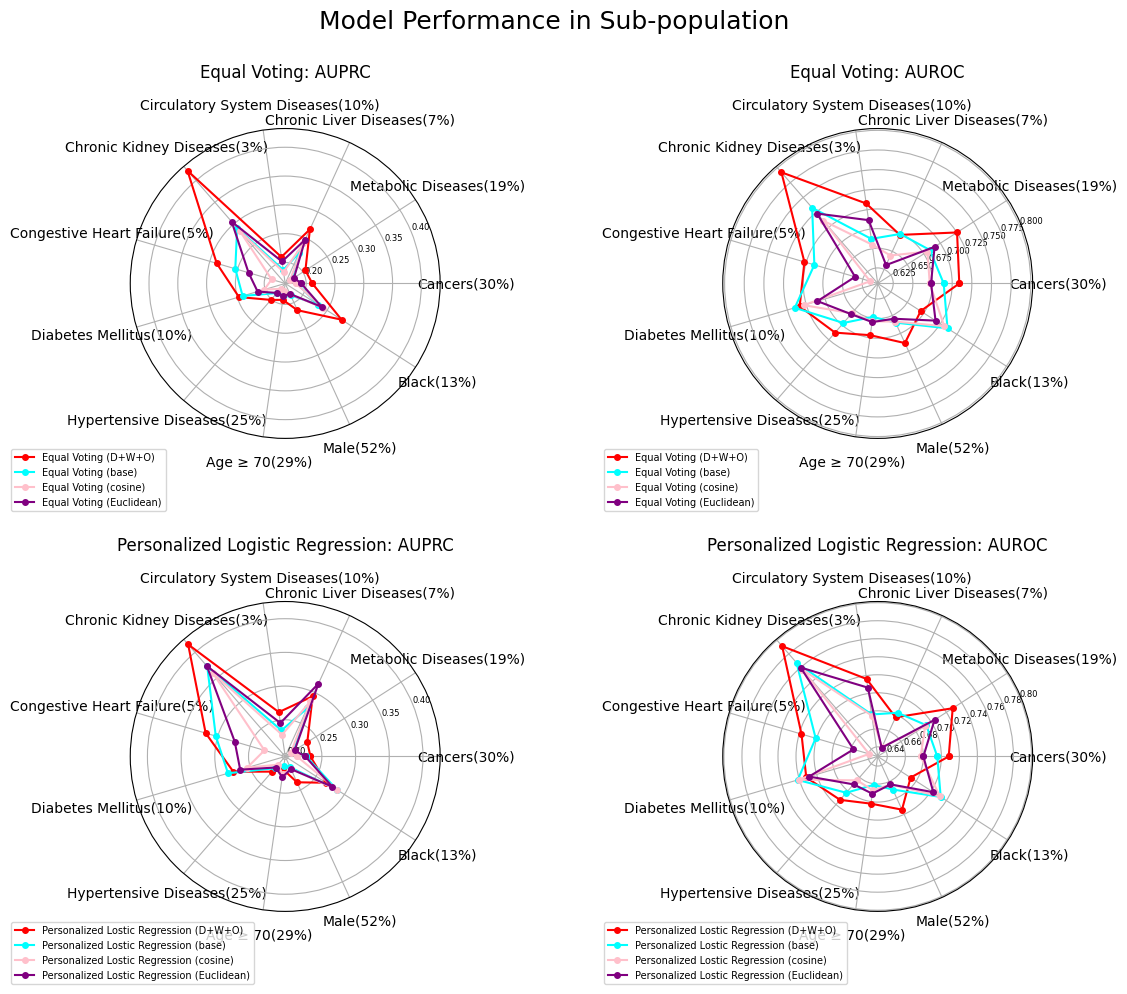

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw=dict(polar=True))

plot_radar(axes[0, 0], subgroup_KNN_performance, pred_prob_KNN.columns, 'AUPRC')
axes[0, 0].set_title("Equal Voting: AUPRC", size=12, pad=15)

plot_radar(axes[0, 1], subgroup_KNN_performance, pred_prob_KNN.columns, 'AUROC')
axes[0, 1].set_title("Equal Voting: AUROC", size=12, pad=15)

plot_radar(axes[1, 0], subgroup_LR_performance, pred_prob_LR.columns, 'AUPRC')
axes[1, 0].set_title("Personalized Logistic Regression: AUPRC", size=12, pad=15)

plot_radar(axes[1, 1], subgroup_LR_performance, pred_prob_LR.columns, 'AUROC')
axes[1, 1].set_title("Personalized Logistic Regression: AUROC", size=12, pad=15)

fig.suptitle("Model Performance in Sub-population", size=18, y=1.00)

plt.tight_layout()
plt.show()